# Modelo de Riqueza
En este modelo se analiza una economía basada en agentes muy simple, extraída de la econofísica y que presenta un enfoque de mecánica estadística para la distribución de la riqueza [ [Dragulescu2002](https://arxiv.org/abs/cond-mat/0211175) ]. 

## Reglas
Las reglas de nuestro modelo son:
* Hay algunos agentes.
* Todos los agentes comienzan con 1 unidad de dinero.
* En cada paso del modelo, un agente entrega 1 unidad de dinero (si la tiene) a otro agente.

A pesar de su simplicidad, este modelo produce resultados que a menudo son inesperados para quienes no están familiarizados con él. Para nuestros propósitos, también demuestra fácilmente las funciones principales de Mesa.

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar a los integrantes de nuestro sistema usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation

# For a jupyter notebook add the following line:
%matplotlib inline
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

## Crear el modelo

In [2]:
class MoneyAgent(Agent):
    '''Un agente con riqueza inicial fija'''
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
    
    def step(self):
        # El paso del agente va aquí
        # Para propositos demostrativos vamos a imprimir el id unico del agente
        #print('Hola, yo soy el agente '+str(self.unique_id)+' con riqueza '+str(self.wealth)+'.')
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    '''Un modelo con algun numero de agentes'''
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        # Crear agentes
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        '''Avanzar el modelo un paso'''
        self.schedule.step()

In [3]:
model = MoneyModel(10)
for i in range(10):
    model.step()

(array([5., 0., 2., 0., 0., 2., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

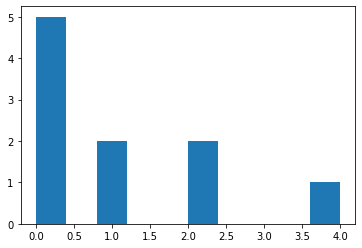

In [4]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([421., 316., 157.,  68.,  28.,   7.,   3.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <BarContainer object of 7 artists>)

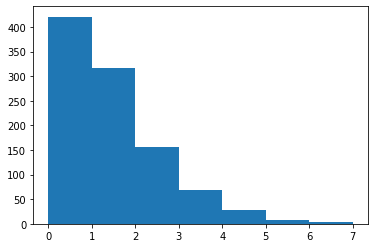

In [5]:
all_wealth = []
# Esto corre el modelo 100 veces, cada modelo se ejecuta 10 pasos
for j in range(100):
    # Correr el modelo
    model = MoneyModel(10)
    for i in range(10):
        model.step()
    
    # Almacenar los resultados
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)
        
plt.hist(all_wealth, bins=range(max(all_wealth)+1))

## Agregando espacio

In [6]:
from mesa.space import MultiGrid

In [7]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [8]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

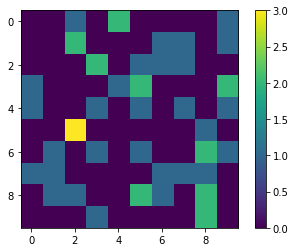

In [9]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

## Collecting Data

In [10]:
from mesa.datacollection import DataCollector

In [11]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [12]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot:>

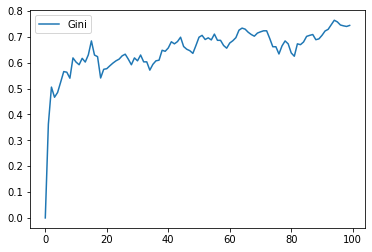

In [13]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [14]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

<AxesSubplot:>

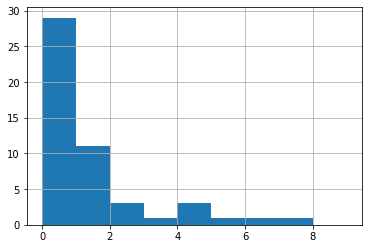

In [15]:
end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

<AxesSubplot:xlabel='Step'>

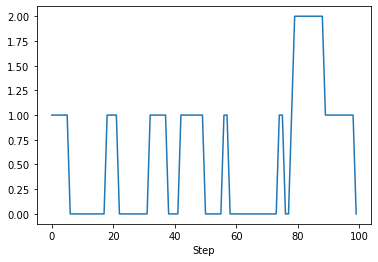

In [16]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

## Batch Run

In [17]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [18]:
from mesa.batchrunner import BatchRunner

In [19]:
fixed_params = {"width": 10,
               "height": 10}
variable_params = {"N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [00:36,  6.77it/s]


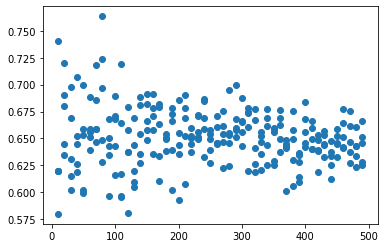

In [45]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

In [46]:
#Get the Agent DataCollection
data_collector_agents = batch_run.get_collector_agents()

data_collector_agents[(10,2)]

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
99   5             0
     6             0
     7             1
     8             2
     9             1

[1000 rows x 1 columns]

In [47]:
#Get the Model DataCollection.

data_collector_model = batch_run.get_collector_model()

data_collector_model[(10,1)]

,Gini
0,0.00
1,0.00
2,0.00
3,0.00
4,0.18
...,...
95,0.74
96,0.74
97,0.74
98,0.74
